<a href="https://colab.research.google.com/github/fastforwardlabs/snorkel-demo-colab/blob/master/snorkel_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training a text classification model using noisy regular expressions

In [1]:
!pip3 install -r requirements.txt
#!pip3 install git+https://github.com/HazyResearch/snorkel
!pip3 install git+https://github.com/nishamuktewar/snorkel
!pip3 install treedlib
!pip3 install numbskull

     |████████████████████████████████| 102kB 32.3MB/s 
     |████████████████████████████████| 829kB 50.9MB/s 
     |████████████████████████████████| 5.7MB 46.9MB/s 
     |████████████████████████████████| 12.9MB 52.0MB/s 
     |████████████████████████████████| 3.3MB 47.8MB/s 
     |████████████████████████████████| 17.3MB 43.1MB/s 
     |████████████████████████████████| 204kB 49.7MB/s 
     |████████████████████████████████| 61kB 24.3MB/s 
     |████████████████████████████████| 24.8MB 1.9MB/s 
     |████████████████████████████████| 5.9MB 46.4MB/s 
     |████████████████████████████████| 51kB 26.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
  Stored in directory: /root/.cache/pip/wheels/38/80/04/b2dbcd5df8afdb529918d2021094048a5917b6e76a6f7b452d
  Stored in directory: /root/.cache/pip/wheels/6b/02/e3/7f1149be63131cdf6aaaa3330924a2683bb530188940569d66
  Stored in directory: /root/.cache/pip/wheels/b4/db/8a/3a3f0c0

  Cloning https://github.com/nishamuktewar/snorkel to /tmp/pip-req-build-wo36ewn0
  Running command git clone -q https://github.com/nishamuktewar/snorkel /tmp/pip-req-build-wo36ewn0
  Stored in directory: /tmp/pip-ephem-wheel-cache-65txfit4/wheels/1c/dc/7b/9cf55b0576fad8e74e4e4c004231d1fd2814b01915d5582ba2
Successfully built snorkel


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import os

In [4]:
from sklearn.model_selection import train_test_split
from collections import Counter
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass, Context, Candidate, StableLabel
from snorkel.contrib.models.text import RawText
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals
from snorkel.learning.tensorflow import TextRNN

W0629 16:40:17.874599 139910103627648 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Download data if it doesn't exist

In [5]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    !curl https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD > ./data/complaints.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  722M    0  722M    0     0  8060k      0 --:--:--  0:01:31 --:--:-- 6153k


### Preprocessing
Data load, filtering out irrelevant fields and rows

Selects two types of products, for example, credit reporting and mortgage. 
Returns dataframe with complaint, and label - 1 = credit reporting complaints, -1 = other (mortgage)

In [6]:
complaints = pd.read_csv(os.path.join(data_dir,'complaints.csv'))
complaints.info()
complaints.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321470 entries, 0 to 1321469
Data columns (total 18 columns):
Date received                   1321470 non-null object
Product                         1321470 non-null object
Sub-product                     1086304 non-null object
Issue                           1321470 non-null object
Sub-issue                       785553 non-null object
Consumer complaint narrative    392072 non-null object
Company public response         469641 non-null object
Company                         1321470 non-null object
State                           1300745 non-null object
ZIP code                        1200789 non-null object
Tags                            180845 non-null object
Consumer consent provided?      714364 non-null object
Submitted via                   1321470 non-null object
Date sent to company            1321470 non-null object
Company response to consumer    1321463 non-null object
Timely response?                1321470 non-null obj

(1321470, 18)

Subset data to include products with narrative

In [0]:
products_w_narrative = complaints[complaints['Product'].notnull() & 
                                  complaints['Consumer complaint narrative'].notnull()]

In [8]:
print(products_w_narrative['Product'].unique())
print(products_w_narrative['Product'].value_counts())

['Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Student loan' 'Credit card or prepaid card' 'Mortgage'
 'Checking or savings account' 'Payday loan, title loan, or personal loan'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Credit card' 'Credit reporting'
 'Bank account or service' 'Consumer Loan' 'Payday loan' 'Prepaid card'
 'Money transfers' 'Other financial service' 'Virtual currency']
Credit reporting, credit repair services, or other personal consumer reports    96097
Debt collection                                                                 88419
Mortgage                                                                        53689
Credit reporting                                                                31588
Credit card or prepaid card                                                     22274
Student loan                                                                    22186
Credi

Combine into one dataframe, create labels (1 for credit reporting, -1 for mortgage)

In [0]:
# credit reporting only
credit_reporting = products_w_narrative[products_w_narrative['Product'] == 'Credit reporting, ' + 
                                 'credit repair services, or other personal consumer reports']
# mortgage only
mortgage = products_w_narrative[products_w_narrative['Product'] == 'Mortgage']

In [0]:
credit_narrative = credit_reporting['Consumer complaint narrative'].values
positive_labels = pd.Series(np.ones(credit_narrative.shape[0]))
positive_df = pd.DataFrame({'complaint': credit_narrative, 'label': positive_labels})

In [0]:
mortgage_narrative = mortgage['Consumer complaint narrative'].values
negative_labels = pd.Series(np.full(mortgage_narrative.shape[0], -1))
negative_df = pd.DataFrame({'complaint': mortgage_narrative, 'label': negative_labels})

In [12]:
complaints_df = pd.concat([positive_df, negative_df], ignore_index=True)
complaints_df.shape

(149786, 2)

In [13]:
complaints_df['label'].value_counts()

 1.0    96097
-1.0    53689
Name: label, dtype: int64

In [0]:
#complaints_df = complaints_df.take(np.random.permutation(len(complaints_df))[:5000])
#complaints_df['label'].value_counts()

Split data into train, dev, test

In [0]:
train, testval = train_test_split(complaints_df, test_size=0.2, random_state=123)
dev, test = train_test_split(testval, test_size=0.5, random_state=123)

### Create noisy labeling functions

Regular expressions that define words, phrases, actions for use in labeling functions

In [0]:
POSITIVE_WORDS = r'\bcredit\b|\breport|\baddress\b|\bcreditor\b|\bexperian\b|\btransunion\b|\bequifax\b|\bfcra\b|\bcollector\b|\bdebt\b|\bconsumer\b'              
POSITIVE_PHRASE = r"\bcredit (report|agency|reporting|bureau|agencies)"
NEGATIVE_WORDS = r'\bloan\b|\bmortgage\b|\bhouse\b|\bhome\b|\bprepayment\b|\bappraise|\bforeclos\btax'
POSITIVE_ACTIONS = r'\bremov|\bdispute\b'
NEGATIVE_ACTIONS = r'\bpredator|\bmodifi\brefinanc'

FRAUD = r'\bfraudulent (account|charges)'
MONEYXFER = r'\bmoney transfer'
CREDIT_REPORTING = r'\b(identity has been compromise(|d)|data breaches|inquiries to businesses|mistakes appear in my report|reporting incorrectly|dispute(|d)|(t|T)ransunion|derogatory|experian|identity theft)'
CREDIT_REPAIR = r'\b(credit repair|hard inquiry|inquiries to businesses|mistakes appear in my report|reporting incorrectly)'


In [0]:
def lf_credit(complaint):
    if re.search(POSITIVE_WORDS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_phrase(complaint):
    if re.search(POSITIVE_PHRASE, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_actions(complaint):
    if re.search(POSITIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_mortgage(complaint):
    if re.search(NEGATIVE_WORDS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0

def lf_mortgage_actions(complaint):
    if re.search(NEGATIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0
    
def lf_fraud(complaint):
    if (re.search(FRAUD, str(complaint), re.IGNORECASE)
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(FRAUD, str(complaint), re.IGNORECASE) 
          and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_reporting(complaint):
    if (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_repair(complaint):
    if (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE) 
        and not re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)
       ):
        return 1
    elif ((re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)) 
          or 
          (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE))
         ):
        return -1
    else:
        return 0

### Generate Snorkel objects

#### Candidates

Candidate objects in Snorkel represent objects to be classified. In this case we are interested in classifying whether a narrative is positive - credit related or not.

In [18]:
session = SnorkelSession()

values = list(complaints_df.label.unique())
print(values)

# snorkel candidate, value if none defaults to binary (true, false)
Narrative = candidate_subclass('Narrative', ['narrative'], values=values)

# Make sure DB is cleared
session.query(Context).delete()
session.query(Candidate).delete()
session.query(StableLabel).delete()

[1.0, -1.0]


0

#### Contexts

All Candidate objects point to one or more Context objects represent the raw data that they are rooted in. In this case, our candidates will each point to a single Context object representing the raw text of the complaint.

Once we have defined the Context for each Candidate, we can commit them to the database. Note that we also split into three sets while doing this:

- Training set (split=0): The narratives for which we have noisy, conflicting labels from our labeling functions; we will resolve these conflicts using the GenerativeModel and then use them as training data for the RNN
- Development set (split=1): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use these to test the RNN's performance on unseen data
- Test set (split=2): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use these to test the RNN's performance on unseen data    

Note: we also store the gold/ annotator labels available for future comparison


In [19]:
train_index = train.index
train.index.str = np.asarray(str(x) for x in train.index)
train_complaints = train.values[:, 0]
train_labels = train.values[:, 1]

for element in zip(train_index, train_complaints, train_labels):
    split = 0
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=0,
                            value=element[2]))
dev_index = dev.index
dev.index.str = np.asarray(str(x) for x in dev.index)
dev_complaints = dev.values[:, 0]
dev_labels = dev.values[:, 1]

for element in zip(dev_index, dev_complaints, dev_labels):
    split = 1
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=1,
                            value=element[2]))

test_index = test.index
test.index.str = np.asarray(str(x) for x in test.index)
test_complaints = test.values[:, 0]
test_labels = test.values[:, 1]

for element in zip(test_index, test_complaints, test_labels):
    split = 2
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=2,
                            value=element[2]))

session.commit()

# number of datapoints
print(session.query(Narrative).count())
# load ground truth labels
train_cand_labels = train_labels
dev_cand_labels = dev_labels
test_cand_labels = test_labels

149786


In [20]:
# test one labeling function
labeled = []
for c in session.query(Narrative).filter(Narrative.split == 1).all():
    if lf_credit(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

Number labeled: 11270


#### Labels

Next, we assign labeling functions for each of the training candidates in a sparse matrix (which will also automatically be saved to the Snorkel database), with one row for each candidate and one column for each label

In [21]:
LFs = [lf_credit, lf_credit_phrase, lf_credit_actions, lf_mortgage, lf_mortgage_actions, lf_fraud, lf_reporting, lf_repair]
# apply labeling functions
labeler = LabelAnnotator(lfs = LFs)
L_train = labeler.apply(split=0)

  0%|          | 27/119828 [00:00<07:30, 266.19it/s]

Clearing existing...
Running UDF...


100%|██████████| 119828/119828 [06:55<00:00, 288.35it/s]


In [22]:
# see what's going on
print(L_train.get_candidate(session, 0))
print(L_train.get_key(session, 0))
print(L_train.lf_stats(session))


Narrative(Raw Text Today, XX/XX/XXXX, I noted an abnormal charge ( from Experian ) on my bank account for {$21.00}. I called the number associated with the transaction and was advised that on XX/XX/XXXX, I signed up for a 7-day trial credit-monitoring service for {$1.00} which would turn into a recurring {$21.00} monthly charge if I failed to cancel the service before the end of the 7-day trial period. 

I honestly don't remember signing up for this service ; I do, however, remember paying {$1.00} to view my credit score when I requested my credit reports from all three credit agencies ( via XXXX ) at the beginning of the year. Is Experian not required to give me more information surrounding my alleged subscription for this service and the terms I allegedly agreed to? 

I have been charged for this credit-monitoring service for the last five months. During the last five months, I have received zero monthly statements for this bill and zero receipts of payment from Experian. The service

### Training generative model

Check if it assumes that the LFs have no dependencies by default?

In [23]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=20, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


### Applying the generative model

#### Probabilistic Label Statistics
We view the distribution of weak labels produced by our generative model.

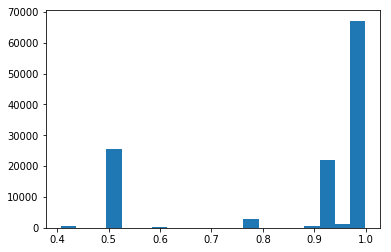

In [24]:
train_marginals = gen_model.marginals(L_train)
plt.hist(train_marginals, bins=20)
plt.show()

### Compare learned accuracies vs empirical accuracies
Learned accuracies from our generative model

In [25]:
accuracy = gen_model.score(L_train, train_cand_labels)
accuracy[0]
print("precision: {:.5f}".format(accuracy[0]), "recall: {:.5f}".format(accuracy[1]), 
      "F-beta: {:.5f}".format(accuracy[2]))

precision: 0.64936 recall: 0.96852 F-beta: 0.77746


In [26]:
# Collect the majority vote answer for each complaint
mv = []
for i in range(L_train.shape[0]):
    if np.diff(L_train[i].indptr) != 0:   #indicates that there is no coverage for a particular datapoint
        c = Counter([L_train[i,j] for j in L_train[i].nonzero()[1]])
        #print(c)
        mv.append(c.most_common(1)[0][0])
        #print(c.most_common(1)[0][0])
    else:
        mv.append(-1) # assume that no label is equivalent to a negative example

mv = np.array(mv)

# Count the number correct by majority vote
n_correct = np.sum([1 for i in range(L_train.shape[0]) if mv[i] == train_cand_labels[i]])
print ("Accuracy:{}".format(n_correct / float(L_train.shape[0])))
print ("Number incorrect:{}".format(L_train.shape[0] - n_correct))

# Compute and return precision, recall, and F1 score
tp = (0.5 * (mv * train_cand_labels + 1))[mv == 1].sum()
pred_pos = mv[mv == 1].sum()
p = tp / float(pred_pos) if pred_pos > 0 else 0.0
pos = train_cand_labels[train_cand_labels == 1].sum()
r = tp / float(pos) if pos > 0 else 0.0

# Compute general F-beta score
beta=1
if p + r > 0:
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r))
else:
    f_beta = 0.0
p, r, f_beta
print("precision: {:.5f}".format(p), "recall: {:.5f}".format(r), "F-beta: {:.5f}".format(f_beta))


Accuracy:0.8155356010281404
Number incorrect:22104
precision: 0.79390 recall: 0.96223 F-beta: 0.87000


We can also get a more detailed score (true positives, false positives, true negatives, false negatives) on the dev set

In [27]:
L_dev = labeler.apply(split=1)
# score it
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_cand_labels)

Clearing existing...


  0%|          | 31/14979 [00:00<00:49, 303.84it/s]

Running UDF...


100%|██████████| 14979/14979 [00:51<00:00, 291.89it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.967
Neg. class accuracy: 0.0629
Precision            0.645
Recall               0.967
F1                   0.774
----------------------------------------
TP: 9233 | FP: 5091 | TN: 342 | FN: 313



Save the predictions of the generative model on the train and test set back to the database

In [28]:
save_marginals(session, L_train, train_marginals)

Saved 119828 marginals


### Training a ML model based on the probabilistic labels

First, load the candidates

In [0]:
train_cands = session.query(Narrative).filter(Narrative.split == 0).order_by(Narrative.id).all()
dev_cands   = session.query(Narrative).filter(Narrative.split == 1).order_by(Narrative.id).all()
test_cands  = session.query(Narrative).filter(Narrative.split == 2).order_by(Narrative.id).all()


Note how the number of training samples are lower than what's present in the training set, it excludes samples where there was no LF coverage (train_marginals.shape[0] - (train_marginals == 0.5).sum())

In [0]:
train_kwargs = {
    'lr':         0.001,
    'dim':        200,
    'n_epochs':   20,
    'dropout':    0.2,
    'print_freq': 1,
    'seed': 123,
    'batch_size': 200,
    'max_sentence_length': 500,
    'vocab_size': 200
}

lstm = TextRNN(seed=123, cardinality=Narrative.cardinality)
# Note: Y_train are the marginals but Y_dev are the gold/ ground truth labels
lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, Y_dev=dev_cand_labels, **train_kwargs)

W0629 16:59:57.848574 139910103627648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/noise_aware_model.py:114: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0629 16:59:57.850262 139910103627648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:74: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 16:59:57.858996 139910103627648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:83: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0629 16:59:57.883962 139910103627648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:90: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0629 16:59:57

max sentence len in training data:  5729
but capped to:  500
And also curtailing warning(s) related to checking individual max sentence lengths in each narrative
currrent vocab size is:  169560
but capped to:  200


W0629 16:59:58.025889 139910103627648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/rnn_cell_impl.py:738: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 16:59:58.367947 139910103627648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/rnn.py:244: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0629 16:59:58.513574 139910103627648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/snorkel/learning/tensorflow/rnn/rnn_base.py:117: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be rem

[TextRNN] Training model
[TextRNN] n_train=115179  #epochs=20  batch size=200
[TextRNN] Epoch 0 (498.61s)	Average loss=0.311905	Dev F1=77.85
[TextRNN] Epoch 1 (1021.51s)	Average loss=0.310351	Dev F1=77.85
[TextRNN] Epoch 2 (1543.62s)	Average loss=0.282915	Dev F1=77.85
[TextRNN] Epoch 3 (2066.77s)	Average loss=0.279703	Dev F1=77.85
[TextRNN] Epoch 4 (2589.51s)	Average loss=0.277743	Dev F1=77.85
[TextRNN] Epoch 5 (3108.95s)	Average loss=0.276681	Dev F1=77.85
[TextRNN] Epoch 6 (3628.54s)	Average loss=0.293467	Dev F1=77.84
[TextRNN] Epoch 7 (4147.77s)	Average loss=0.286906	Dev F1=77.85
[TextRNN] Epoch 8 (4665.95s)	Average loss=0.282406	Dev F1=77.85
[TextRNN] Epoch 9 (5184.49s)	Average loss=0.280227	Dev F1=77.85
[TextRNN] Epoch 10 (5702.60s)	Average loss=0.279259	Dev F1=77.85
[TextRNN] Epoch 11 (6219.97s)	Average loss=0.278339	Dev F1=77.85
[TextRNN] Epoch 12 (6738.89s)	Average loss=0.277385	Dev F1=77.85
[TextRNN] Epoch 13 (7260.70s)	Average loss=0.276593	Dev F1=77.86


#### Accuracies on dev and test datasets

In [0]:
accuracy_dev = lstm.score(dev_cands, dev_cand_labels, batch_size=200)
print("precision: {:.5f}".format(accuracy_dev[0]), "recall: {:.5f}".format(accuracy_dev[1]), 
      "F-beta: {:.5f}".format(accuracy_dev[2]))

In [0]:
accuracy_test = lstm.score(test_cands, test_cand_labels, batch_size=200)
print("precision: {:.5f}".format(accuracy_test[0]), "recall: {:.5f}".format(accuracy_test[1]), 
      "F-beta: {:.5f}".format(accuracy_test[2]))

In [0]:
# convert df back to csv, with column names
train["train_marginals"] = train_marginals
train.to_csv(data_dir+'/train.csv', index=False)
test.to_csv(data_dir+'/test.csv', index=False)
dev.to_csv(data_dir+'/dev.csv', index=False)